In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hydroeval as he
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("--- All libraries imported. ---")

df = pd.read_csv('../data/processed/model_ready_data.csv', index_col='date', parse_dates=True)
print("✅ Model-ready data loaded successfully.")


y = df['target_discharge_t+7']
X = df.drop(columns=['discharge', 'target_discharge_t+7'])
print("✅ Features (X) and Target (y) are defined.")

split_date = '2005-01-01'
X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]
X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]
print(f"✅ Data successfully split. Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

--- All libraries imported. ---
✅ Model-ready data loaded successfully.
✅ Features (X) and Target (y) are defined.
✅ Data successfully split. Training samples: 8737, Testing samples: 782


In [2]:
# =================================================================
# 4. SCALE THE DATA (Normalize 0-1)
# =================================================================
# This is a critical step for all neural networks.

# Initialize the scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler() # We scale y separately

# --- CRITICAL: We fit the scaler ONLY on the training data ---
# This prevents "data leakage" (peeking at the test set's answers)
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# --- We ONLY transform the test data ---
# We use the scaler that was "fit" to the training data.
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("✅ Data successfully scaled.")
print(f"Shape of scaled training features: {X_train_scaled.shape}")
print(f"Shape of scaled testing features: {X_test_scaled.shape}")

✅ Data successfully scaled.
Shape of scaled training features: (8737, 19)
Shape of scaled testing features: (782, 19)


In [3]:

def create_sequences(X, y, sequence_length=30):
    """
    This function takes our 2D feature and target arrays and converts them
    into 3D sequences that the LSTM can understand.
    """
    X_sequences, y_sequences = [], []
    for i in range(len(X) - sequence_length):
        # Find the end of this pattern
        end_ix = i + sequence_length
        
        # gather input and output parts of the pattern
        seq_x, seq_y = X[i:end_ix], y[end_ix]
        
        X_sequences.append(seq_x)
        y_sequences.append(seq_y)
        
    return np.array(X_sequences), np.array(y_sequences)

# Define the sequence length (timesteps)
# We'll use the last 30 days of data to predict the future.
SEQUENCE_LENGTH = 30

# Create the sequences for the training and testing sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQUENCE_LENGTH)

print("✅ Data successfully reshaped into sequences.")
print(f"Shape of training sequences (X): {X_train_seq.shape}")
print(f"Shape of training targets (y): {y_train_seq.shape}")
print(f"Shape of testing sequences (X): {X_test_seq.shape}")
print(f"Shape of testing targets (y): {y_test_seq.shape}")

✅ Data successfully reshaped into sequences.
Shape of training sequences (X): (8707, 30, 19)
Shape of training targets (y): (8707, 1)
Shape of testing sequences (X): (752, 30, 19)
Shape of testing targets (y): (752, 1)


In [4]:

# Initialize the neural network
model_lstm = Sequential()

# Add the first LSTM layer
# 'input_shape' is crucial: (timesteps, features)
model_lstm.add(LSTM(
    units=50, 
    return_sequences=True,  # True because we are stacking another LSTM layer
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
))
model_lstm.add(Dropout(0.2)) # Prevents overfitting

# Add a second LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=False)) # False on the last LSTM layer
model_lstm.add(Dropout(0.2))

# Add the final Dense output layer that gives us our 1 prediction
model_lstm.add(Dense(units=1))

# 'compile' configures the model for training.
# 'optimizer='adam'' is an efficient algorithm for finding the best model weights.
# 'loss='mean_squared_error'' tells the model to minimize the squared error.
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of our model's architecture
print("✅ Model Built and Compiled Successfully.")
model_lstm.summary()

✅ Model Built and Compiled Successfully.


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          14,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,251 (133.79 KB)

 Trainable params: 34,251 (133.79 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:

print("Starting model training... This will take a while.")

# history will store the training progress for later visualization
history = model_lstm.fit(
    X_train_seq,
    y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # We use 20% of our training data as a "quiz"
    verbose=1 # This will print the progress for each epoch
)

print("\n✅✅ Model training complete!")

Starting model training... This will take a while.
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0036 - val_los

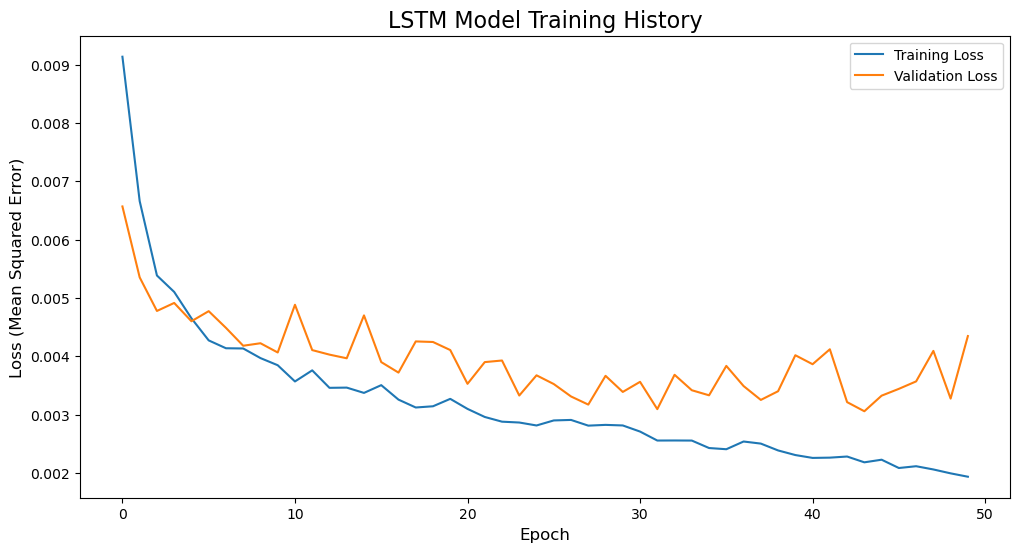

In [6]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend()
plt.savefig('../figures/lstm_training_history.png', dpi=300)
plt.show()

In [7]:

print("--- Making predictions on unseen test data ---")
# 1. Predict the scaled values
y_pred_scaled = model_lstm.predict(X_test_seq)

# 2. Inverse transform the predictions (back to m³/s)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

# 3. Inverse transform the *actual* test values for a fair comparison
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# 4. Create a results DataFrame
# CRITICAL: We must align our predictions with the correct dates.
# We lost 'SEQUENCE_LENGTH' (30) days from the start of the test set,
# so we must use the index from that point forward.
results_lstm = pd.DataFrame({
    'Observed': y_test_actual.flatten(),
    'Predicted_LSTM': y_pred_lstm.flatten()
}, index=y_test.index[SEQUENCE_LENGTH:])

print("✅ Predictions complete and inverse-scaled.")

print("\n--- Evaluating LSTM Model ---")
rmse_lstm = np.sqrt(mean_squared_error(results_lstm['Observed'], results_lstm['Predicted_LSTM']))
mae_lstm = mean_absolute_error(results_lstm['Observed'], results_lstm['Predicted_LSTM'])
r2_lstm = r2_score(results_lstm['Observed'], results_lstm['Predicted_LSTM'])
nse_lstm = he.evaluator(he.nse, results_lstm['Predicted_LSTM'], results_lstm['Observed'])[0]

# --- THE FINAL SCORECARD ---
print("--- LSTM Model Performance Metrics ---")
print(f"Root Mean Square Error (RMSE): {rmse_lstm:.2f} m³/s")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f} m³/s")
print(f"R-squared (R²): {r2_lstm:.2f}")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse_lstm:.2f}")

print("\n--- Baseline MLR Performance (for comparison) ---")
print("MLR RMSE: 96.93 m³/s")
print("MLR NSE: 0.85")

--- Making predictions on unseen test data ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 
✅ Predictions complete and inverse-scaled.

--- Evaluating LSTM Model ---
--- LSTM Model Performance Metrics ---
Root Mean Square Error (RMSE): 117.44 m³/s
Mean Absolute Error (MAE): 65.78 m³/s
R-squared (R²): 0.78
Nash-Sutcliffe Efficiency (NSE): 0.78

--- Baseline MLR Performance (for comparison) ---
MLR RMSE: 96.93 m³/s
MLR NSE: 0.85



--- Plotting LSTM Results ---


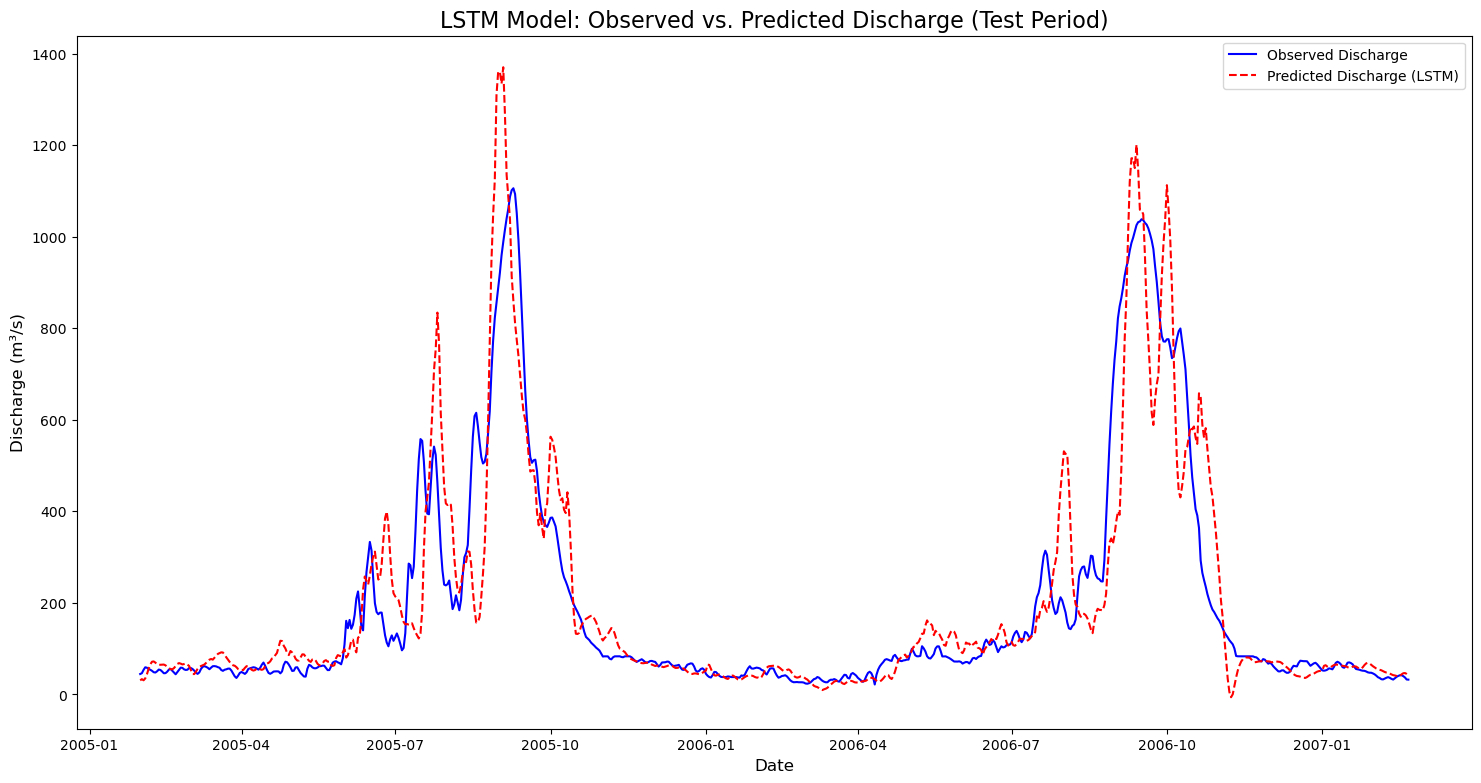

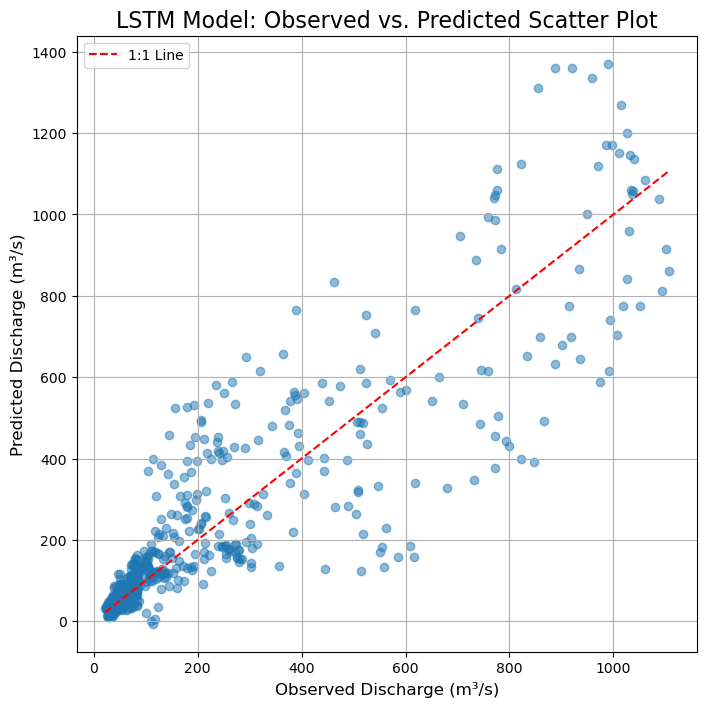

In [8]:

print("\n--- Plotting LSTM Results ---")

# --- Plot 1: Time Series Comparison ---
plt.figure(figsize=(18, 9))
plt.plot(results_lstm.index, results_lstm['Observed'], label='Observed Discharge', color='blue')
plt.plot(results_lstm.index, results_lstm['Predicted_LSTM'], label='Predicted Discharge (LSTM)', color='red', linestyle='--')
plt.title('LSTM Model: Observed vs. Predicted Discharge (Test Period)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge (m³/s)', fontsize=12)
plt.legend()
plt.savefig('../figures/lstm_timeseries_plot.png', dpi=300)
plt.show()

# --- Plot 2: Scatter Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(results_lstm['Observed'], results_lstm['Predicted_LSTM'], alpha=0.5)
plt.plot([min(results_lstm['Observed']), max(results_lstm['Observed'])], 
         [min(results_lstm['Observed']), max(results_lstm['Observed'])], 
         color='red', linestyle='--', label='1:1 Line')
plt.title('LSTM Model: Observed vs. Predicted Scatter Plot', fontsize=16)
plt.xlabel('Observed Discharge (m³/s)', fontsize=12)
plt.ylabel('Predicted Discharge (m³/s)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('../figures/lstm_scatter_plot.png', dpi=300)
plt.show()